# **Homework 3** 

Dataset scaricato in: /kaggle/input/cifar10-hw3
Contenuto della sottocartella: ['y_train.npy', 'y_test.npy', 'y_val.npy', 'x_test.npy', 'x_val.npy', 'x_train.npy']
Shapes:
x_train: (40000, 32, 32, 3) y_train: (40000,)
x_val: (10000, 32, 32, 3) y_val: (10000,)
x_test: (10000, 32, 32, 3) y_test: (10000,)
Sotto-campionamento: training set ridotto a 5000 campioni
x_trainval shape: (15000, 3072)
y_trainval shape: (15000,)
Grid Search
Fitting 3 folds for each of 6 candidates, totalling 18 fits

Migliori iperparametri trovati: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.001}
Miglior accuratezza validazione incrociata: 0.4217

Accuratezza finale sul test set: 0.4490

Classification report sul test set:
              precision    recall  f1-score   support

           0       0.51      0.52      0.52      1000
           1       0.56      0.57      0.56      1000
           2       0.37      0.24      0.29      1000
           3       0.27   

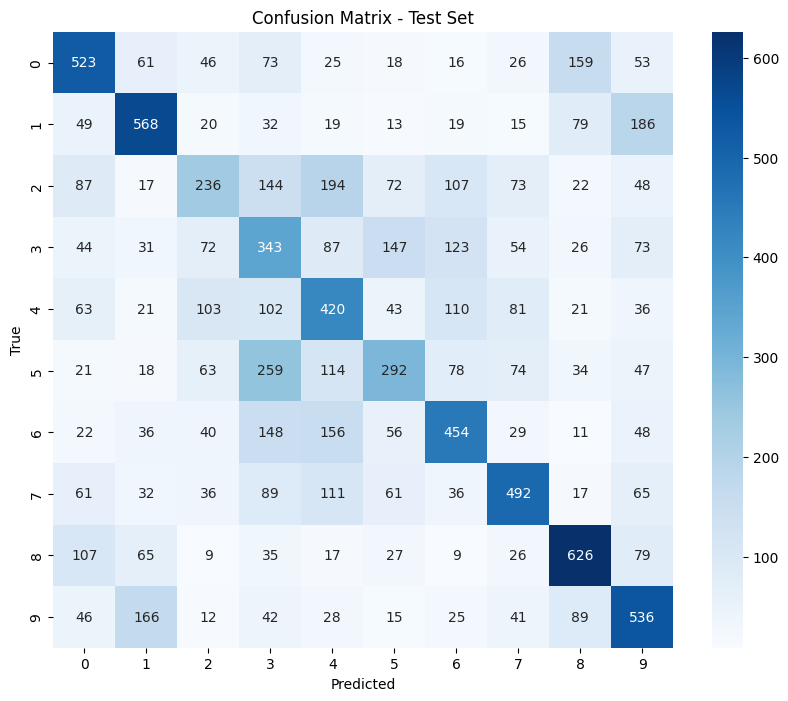

In [14]:
import numpy as np
import kagglehub
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


path = kagglehub.dataset_download("alessiomasano/cifar10-hw3")
print("Dataset scaricato in:", path)

data_dir = os.path.join(path, 'cifar_hw3')
print("Contenuto della sottocartella:", os.listdir(data_dir))

x_train = np.load(os.path.join(data_dir, 'x_train.npy'))
y_train = np.load(os.path.join(data_dir, 'y_train.npy')).ravel()
x_val = np.load(os.path.join(data_dir, 'x_val.npy'))
y_val = np.load(os.path.join(data_dir, 'y_val.npy')).ravel()
x_test = np.load(os.path.join(data_dir, 'x_test.npy'))
y_test = np.load(os.path.join(data_dir, 'y_test.npy')).ravel()

print("Shapes:")
print("x_train:", x_train.shape, "y_train:", y_train.shape)
print("x_val:", x_val.shape, "y_val:", y_val.shape)
print("x_test:", x_test.shape, "y_test:", y_test.shape)

# Flatten immagini (da 32x32x3 a 3072)
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_val_flat = x_val.reshape((x_val.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

# Sotto-campionamento sul training set flattenato
subsample_size = 5000  # scegli quanti campioni vuoi mantenere

if subsample_size < x_train_flat.shape[0]:
    np.random.seed(42)
    indices = np.random.choice(x_train_flat.shape[0], subsample_size, replace=False)
    x_train_flat = x_train_flat[indices]
    y_train = y_train[indices]
    print(f"Sotto-campionamento: training set ridotto a {subsample_size} campioni")


# Normalizzazione
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_flat)
x_val_scaled = scaler.transform(x_val_flat)
x_test_scaled = scaler.transform(x_test_flat)

# Unione train + val per grid search
x_trainval = np.concatenate([x_train_scaled, x_val_scaled], axis=0)
y_trainval = np.concatenate([y_train, y_val], axis=0)

print(f"x_trainval shape: {x_trainval.shape}")
print(f"y_trainval shape: {y_trainval.shape}")

mlp = MLPClassifier(
    max_iter=200,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    tol=1e-4,
    warm_start=False
)

param_grid = {
    'hidden_layer_sizes': [(128,), (256,), (256, 128)],
    'alpha': [0.0001, 0.001],  # L2 regularization
    'learning_rate_init': [0.001],
    'activation': ['relu']
}

# GridSearch con validazione incrociata a 3 fold
grid_search = GridSearchCV(
    mlp,
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2,
    n_jobs=-1
)

print("Grid Search")
grid_search.fit(x_trainval, y_trainval)

print(f"\nMigliori iperparametri trovati: {grid_search.best_params_}")
print(f"Miglior accuratezza validazione incrociata: {grid_search.best_score_:.4f}")

# Valutazione finale sul test set con miglior modello
best_model = grid_search.best_estimator_
test_pred = best_model.predict(x_test_scaled)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"\nAccuratezza finale sul test set: {test_accuracy:.4f}")

# Report di classificazione completo
print("\nClassification report sul test set:")
print(classification_report(y_test, test_pred))

# Matrice di confusione
cm = confusion_matrix(y_test, test_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
